# Cal-CRAI Domain Score: Natural Systems

**Order of operations**: 
1) Metric handling \
   1a - Retrieve data \
   1b - Min-max standardization \
   1c - Set vulnerability orientation (positive for when a larger value represents greater vulnerability, negative for when a larger value corresponds to decreased vulnerability)

2) Calculate indicators \
   2a - Min-max standardization \
   2b - Finalize domain score
   
3) Visualize, save, and export domain score dataframe

In [1]:
import pandas as pd
import os
import sys

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.cal_crai_plotting import plot_domain_score, plot_region_domain
from scripts.utils.cal_crai_calculations import (min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


Process and merge Natural System metric files together

In [3]:
# domain-specific
domain_prefix = 'natural_'
input_folder = r'aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'../utils/calcrai_metrics.csv'

merged_output_file = f'concatenate_{domain_prefix}metrics.csv'
metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 9 CSV files within natural_domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_natural_metrics.csv


Take a look at the resulting dictionary: We will use this later to refactor 'resilient' metrics!

In [4]:
metric_vulnerable_resilient_dict

{'vulnerable': ['tract_percent_impervious',
  'esi_mean',
  'ssma_mean',
  'CRI Metric Percentage',
  'percent_vulnerable_soils',
  'percent_vulnerable_drought',
  'percent_vulnerable_fire'],
 'resilient': ['protected_areas_percentage', 'SpBioWtEco']}

Now, take a look at the merged singluar csv file

In [5]:
# read-in and view processed data
processed_natural_df = pd.read_csv(merged_output_file)
processed_natural_df.head()

,GEOID,tract_percent_impervious,protected_areas_percentage,SpBioWtEco,esi_mean,ssma_mean,CRI Metric Percentage,percent_vulnerable_soils,percent_vulnerable_drought,percent_vulnerable_fire
0,6085504321,61.995523,NaN,0.353149,-0.256612,-0.150536,4.176877,56.85,71.6,59.7
1,6085504410,62.459839,1.369569,0.350678,-0.248534,-0.150536,4.176877,56.85,71.6,59.7
2,6085507003,6.223214,34.535639,0.493177,-0.006297,-0.182977,4.176877,56.85,71.6,59.7
3,6085507004,43.193380,0.975427,0.560144,-0.066103,-0.182977,4.176877,56.85,71.6,59.7
4,6085502204,64.845221,2.391541,0.317580,0.020351,-0.163483,4.176877,56.85,71.6,59.7


### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [6]:
# standardizing our df
columns_to_process = [col for col in processed_natural_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_natural_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


Isolate for GEOID and standardized columns exclusively

In [7]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_natural_metrics_df = min_max_metrics[selected_columns]
min_max_standardized_natural_metrics_df.head()

,GEOID,tract_percent_impervious_min_max_standardized,protected_areas_percentage_min_max_standardized,SpBioWtEco_min_max_standardized,esi_mean_min_max_standardized,ssma_mean_min_max_standardized,CRI Metric Percentage_min_max_standardized,percent_vulnerable_soils_min_max_standardized,percent_vulnerable_drought_min_max_standardized,percent_vulnerable_fire_min_max_standardized
0,6085504321,0.619955,NaN,0.291250,0.437104,0.454346,0.097706,0.614595,0.722597,0.179372
1,6085504410,0.624598,0.013818,0.288282,0.439449,0.454346,0.097706,0.614595,0.722597,0.179372
2,6085507003,0.062232,0.348452,0.459432,0.509767,0.398706,0.097706,0.614595,0.722597,0.179372
3,6085507004,0.431934,0.009842,0.539865,0.492406,0.398706,0.097706,0.614595,0.722597,0.179372
4,6085502204,0.648452,0.024130,0.248529,0.517503,0.432140,0.097706,0.614595,0.722597,0.179372


### 1c) Set resilience orientation
* High values indicate resiliency
* Low values indicate vulnerablility

Some metrics indicate a communities vulnerablity rather than resilience. For example, 'percent_vulnerable_soils' represents a communities vulnerability to poor soil. For this metric, the higher the number, the more vulnerable. So we identify these 'vulnerable' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate resiliency

In [8]:
metric_vulnerable_resilient_dict

{'vulnerable': ['tract_percent_impervious',
  'esi_mean',
  'ssma_mean',
  'CRI Metric Percentage',
  'percent_vulnerable_soils',
  'percent_vulnerable_drought',
  'percent_vulnerable_fire'],
 'resilient': ['protected_areas_percentage', 'SpBioWtEco']}

In [9]:
# Access the vulnerable column names from the dictionary
vulnerable_columns = metric_vulnerable_resilient_dict['vulnerable']

# Identify columns in the DataFrame that contain any of the vulnerable column names as substrings
vulnerable_columns_in_df = [col for col in min_max_standardized_natural_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in vulnerable_columns)]

# Create a new DataFrame with the adjusted vulnerable columns
adjusted_vulnerable_df = min_max_standardized_natural_metrics_df.copy()

# Subtract the standardized vulnerable columns from one and store the result in the new DataFrame
adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df] = (
    1 - adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df]
)
adjusted_vulnerable_df.head()

,GEOID,tract_percent_impervious_min_max_standardized,protected_areas_percentage_min_max_standardized,SpBioWtEco_min_max_standardized,esi_mean_min_max_standardized,ssma_mean_min_max_standardized,CRI Metric Percentage_min_max_standardized,percent_vulnerable_soils_min_max_standardized,percent_vulnerable_drought_min_max_standardized,percent_vulnerable_fire_min_max_standardized
0,6085504321,0.380045,NaN,0.291250,0.562896,0.545654,0.902294,0.385405,0.277403,0.820628
1,6085504410,0.375402,0.013818,0.288282,0.560551,0.545654,0.902294,0.385405,0.277403,0.820628
2,6085507003,0.937768,0.348452,0.459432,0.490233,0.601294,0.902294,0.385405,0.277403,0.820628
3,6085507004,0.568066,0.009842,0.539865,0.507594,0.601294,0.902294,0.385405,0.277403,0.820628
4,6085502204,0.351548,0.024130,0.248529,0.482497,0.567860,0.902294,0.385405,0.277403,0.820628


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [10]:
domain_prefix[:-1]

'natural'

In [12]:
averaged_indicators_natural_systems = compute_averaged_indicators(
    adjusted_vulnerable_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_natural_systems.head(5)

,GEOID,agricultural_productivity_conservation,ecosystem_condition
0,6085504321,0.554275,0.430946
1,6085504410,0.553102,0.360156
2,6085507003,0.545764,0.538181
3,6085507004,0.554444,0.433535
4,6085502204,0.525179,0.351274


Save Indicator dataframe as a csv

In [13]:
# set-up file for export
indicator_filename = '{}domain_averaged_indicators.csv'.format(domain_prefix)
averaged_indicators_natural_systems.to_csv(indicator_filename, index=False)

Sum the indicator columns together to calculate the domain score
* essentially summing all columns except for 'GEOID'

In [14]:
columns_to_sum = [col for col in averaged_indicators_natural_systems.columns if col != 'GEOID']
summed_indicators_natural_systems = compute_summed_indicators(
    df=averaged_indicators_natural_systems, 
    columns_to_sum=columns_to_sum,
    domain_prefix=domain_prefix
)

Indicator sum min value: 0.0
Indicator sum max value: 1.5462914445295695


### 2a) Min-max standardize the summed columns

In [15]:
columns_to_process = [col for col in summed_indicators_natural_systems.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_natural_systems, columns_to_process)
min_max_domain.head()

All standardized columns are within the [0, 1] range (considering tolerance).


,GEOID,summed_indicators_natural_domain_min,summed_indicators_natural_domain_max,summed_indicators_natural_domain_min_max_standardized
0,6085504321,0.0,1.546291,0.637151
1,6085504410,0.0,1.546291,0.590612
2,6085507003,0.0,1.546291,0.700996
3,6085507004,0.0,1.546291,0.638934
4,6085502204,0.0,1.546291,0.566809


### 2b) Finalize domain score
* Isolate to census tract and summed standardized columns
* Rename tract to GEOID for merging
* Rename domain score column
* Add a zero at the beginning of the GEOID to match census tract that will be merged

In [17]:
natural_systems_domain_score = min_max_domain[['GEOID', 'summed_indicators_natural_domain_min_max_standardized']].copy()

# GEOID handling
natural_systems_domain_score['GEOID'] = natural_systems_domain_score['GEOID'].apply(lambda x: '0' + str(x))
natural_systems_domain_score['GEOID'] = natural_systems_domain_score['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)
natural_systems_domain_score = natural_systems_domain_score.rename(columns={'summed_indicators_natural_domain_min_max_standardized':'natural_systems_domain_score'})
natural_systems_domain_score.head()

,GEOID,natural_systems_domain_score
0,06085504321,0.637151
1,06085504410,0.590612
2,06085507003,0.700996
3,06085507004,0.638934
4,06085502204,0.566809


## Step 3: Visualize, save, and export domain score

Let's look at some summary statistics for this domain:

In [18]:
domain_summary_stats(natural_systems_domain_score, 'natural_systems_domain_score')

Median natural_systems_domain_score domain value: 0.5821807395864517
Mean natural_systems_domain_score domain value: 0.5752624535414119


Now let's visualize the entire domain!

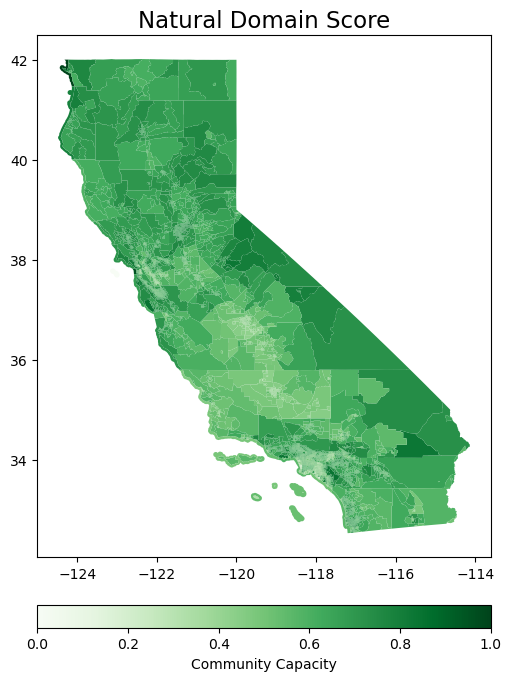

In [19]:
plot_domain_score(natural_systems_domain_score, column_to_plot='natural_systems_domain_score', domain=domain_prefix)

### We can also visualize specific areas!
Here we'll use the specialized plotting function `plot_region_domain` function, which can handle county identifiers (their corresponding FIPS code) and pre-defined CA regions (listed below). For more information on the function, type `help(plot_region_domain)` to display additional context for all arguments. 

Pre-defined regions include: `bay_area`, `central_region`, `inland_deserts`, `north_central`, `northern`, `south_coast`, `slr_coast`. 

CA County FIPS Code Look-Up Table
|County: Code|County: Code|County: Code|County: Code|
|-----|----|-----|-----|
|Alameda: 001|Lassen: 035|San Benito: 069|Tehama: 103|
|Alpine: 003|Los Angeles: 037|San Bernardino: 071|Trinity: 105|
|Amador: 005|Madera: 039|San Diego: 073|Tulare: 107|
|Butte: 007|Marin: 041|San Francisco: 075|Tuolumne: 109|
|Calaveras: 009|Mariposa: 043|San Joaquin: 077|Ventura: 111|
|Colusa: 013|Mendocino: 045|San Luis Obispo: 079|Yolo: 113|
|Contra Costa: 015|Merced: 047|San Mateo: 081|Yuba: 115|
|Del Norte: 017|Modoc: 049| Santa Barbara: 083|
|El Dorado: 019|Mono: 051|Santa Clara: 085|
|Fresno: 019|Monterey: 053|Santa Cruz: 087|
|Glenn: 021|Napa: 055|Shasta: 089|
|Humboldt: 023|Nevada: 057|Sierra: 091|
|Imperial: 025|Orange: 059|Siskiyou: 095|
|Inyo: 027|Placer: 061|Solano: 095|
|Kern: 029|Plumas: 063|Sonoma: 097|
|Kings: 031|Riverside: 065|Stanislaus: 099|
|Lake: 033|Sacramento: 067|Sutter: 101|

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels. Below are a few example of each of these plotting scenarios. 

`help(plot_region_domain)`

Number of invalid geometries: 0


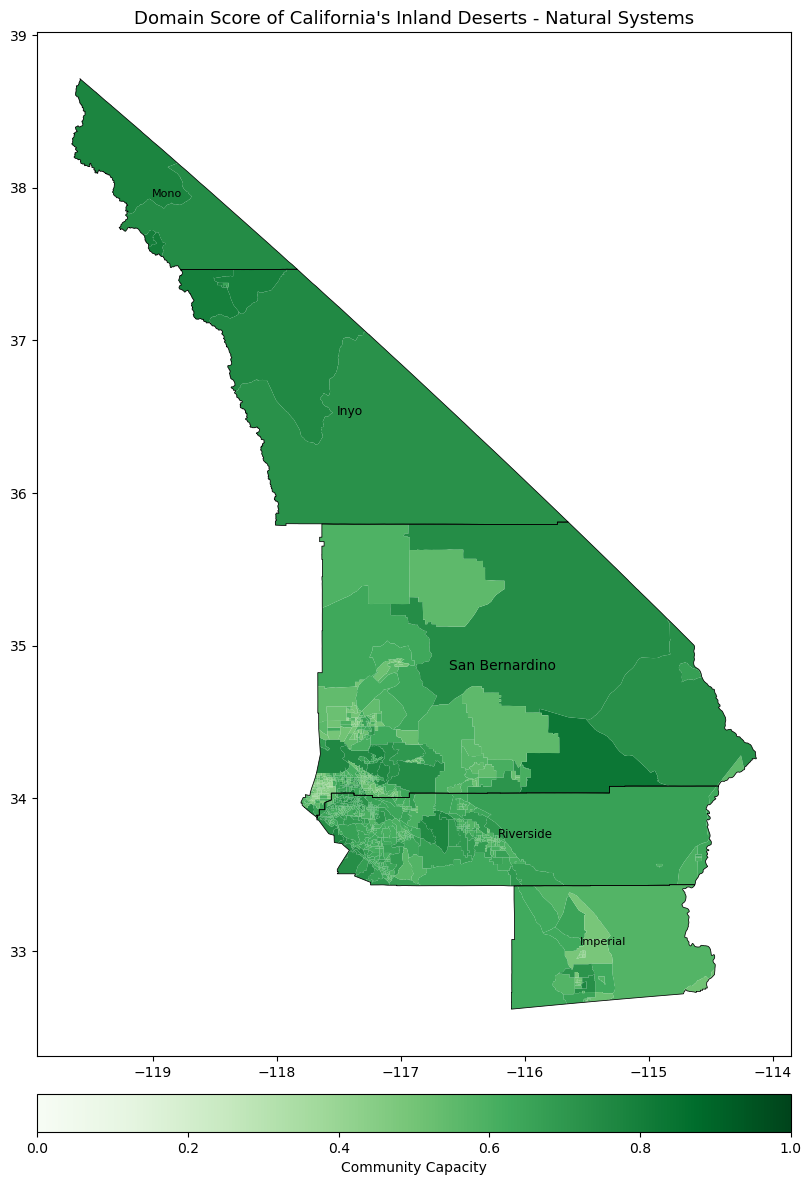

In [20]:
plot_region_domain(natural_systems_domain_score,
                    column_to_plot='natural_systems_domain_score',
                    domain=domain_prefix, 
                    domain_label_map={domain_prefix: 'Natural Systems'},
                    region='inland_deserts', 
                    savefig=False, 
                    font_color='black')

Number of invalid geometries: 0


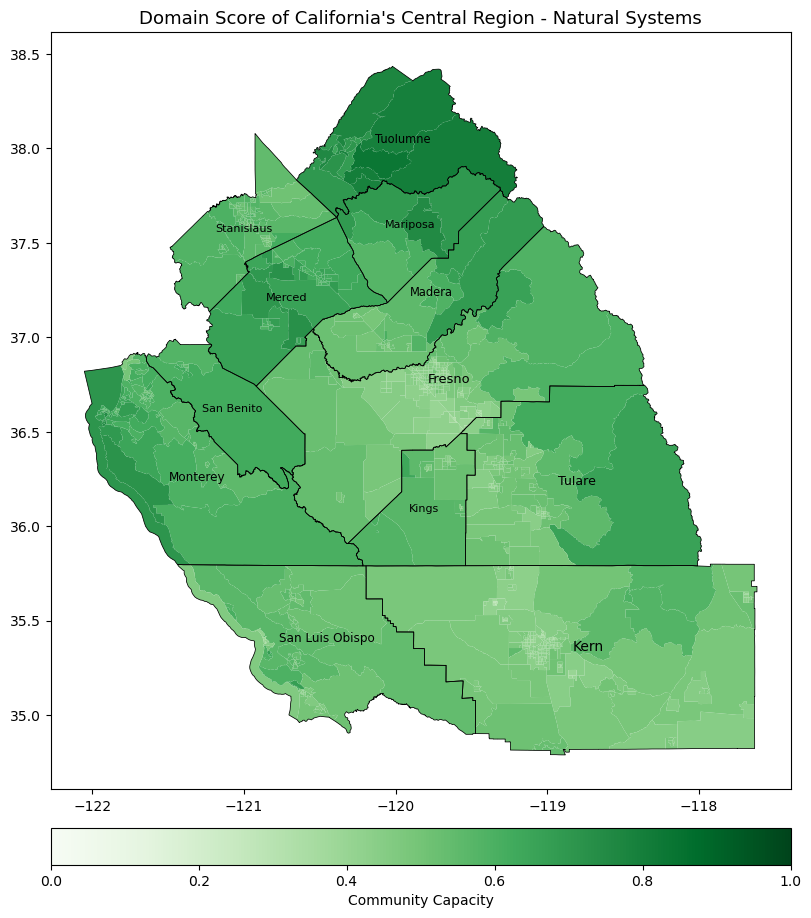

In [21]:
plot_region_domain(natural_systems_domain_score,
                    column_to_plot='natural_systems_domain_score',
                    domain=domain_prefix, 
                    domain_label_map={domain_prefix: 'Natural Systems'},
                    region='central_region', 
                    savefig=False,
                    font_color='black')

Number of invalid geometries: 0


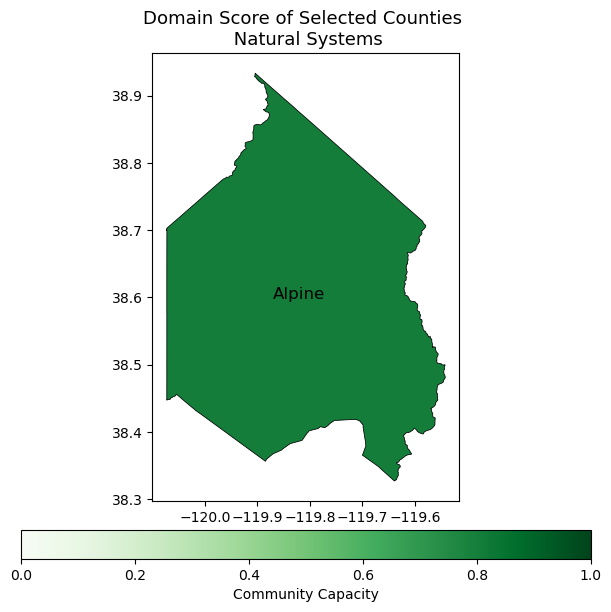

In [22]:
list_of_counties = ['003']
plot_region_domain(natural_systems_domain_score,
                    column_to_plot='natural_systems_domain_score', 
                    domain=domain_prefix, 
                    domain_label_map={domain_prefix: 'Natural Systems'}, 
                    counties_to_plot=list_of_counties, 
                    savefig=False, 
                    font_color='black')

Number of invalid geometries: 0


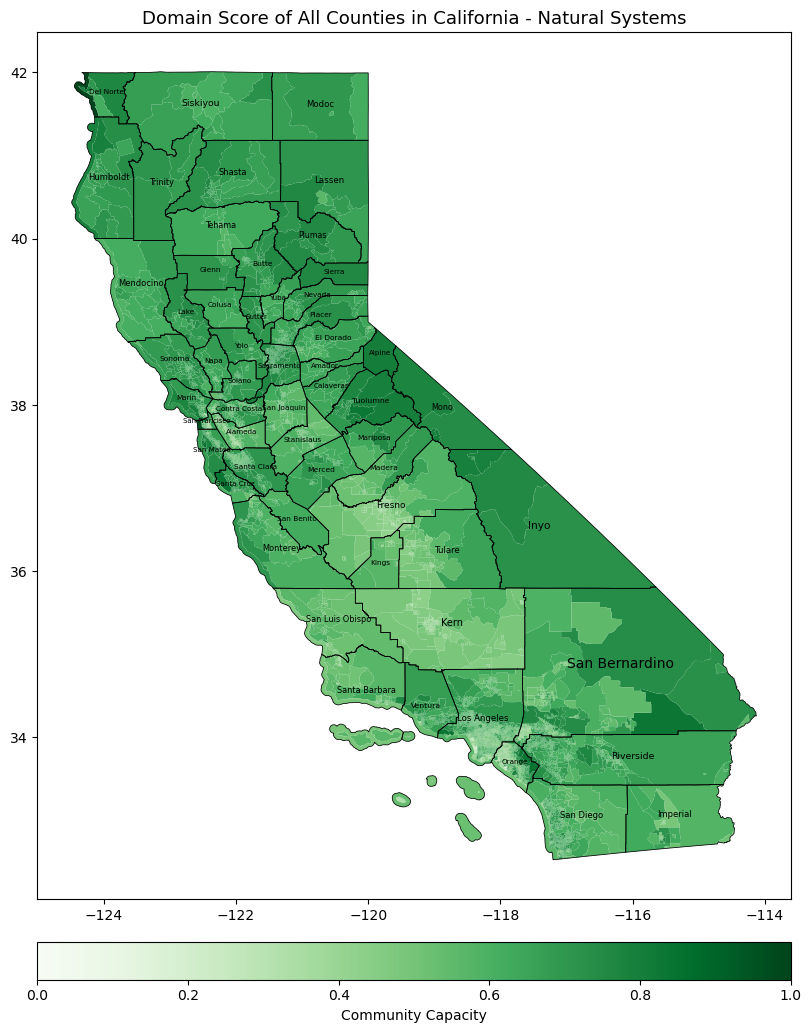

In [23]:
plot_region_domain(natural_systems_domain_score,
                    column_to_plot='natural_systems_domain_score',
                    domain=domain_prefix, 
                    domain_label_map={domain_prefix: 'Natural Systems'}, 
                    plot_all=True,
                    savefig=False, 
                    font_color='black')

## Export the final domain csv file

In [24]:
# set-up file for export
domain_filename = '{}systems_domain_score.csv'.format(domain_prefix)
natural_systems_domain_score.to_csv(domain_filename, index=False)

## Upload the indicator and domain score csv files to AWS

In [25]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files_upload = indicator_filename, domain_filename

for file in files_upload:
    upload_csv_aws([file], bucket_name, directory)

natural_domain_averaged_indicators.csv uploaded to AWS
natural_systems_domain_score.csv uploaded to AWS
